In [1]:
import gc
import glob
import os
import time
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import pyarrow

In [2]:
DATA_DIR = './input/optiver-realized-volatility-prediction'

In [3]:
book_feature = pd.read_parquet(os.path.join(DATA_DIR,  'order_book_feature.parquet'))
book_target = pd.read_parquet(os.path.join(DATA_DIR,  'order_book_target.parquet'))
train = pd.read_csv(os.path.join(DATA_DIR,  'train.csv'))
trade = pd.read_parquet(os.path.join(DATA_DIR,  'trades.parquet'))

In [4]:
for col in train.columns:
    print(col,":",len(train[col].unique()))

time_id : 1152
stock_id : 10
target : 11520


In [5]:
print(book_feature["stock_id"].value_counts()) 

50200     2072533
104919    2072317
9323      2067621
22951     1961927
8382      1943101
22753     1853526
22675     1637650
22771     1463176
22729     1325325
48219     1248943
Name: stock_id, dtype: int64


In [6]:
train.describe()

,time_id,stock_id,target
count,11520.00000,11520.000000,11520.000000
mean,608.09375,33492.200000,0.004103
std,342.63374,27179.735741,0.002523
min,12.00000,8382.000000,0.000347
25%,311.75000,22675.000000,0.002326
50%,605.50000,22762.000000,0.003688
75%,905.25000,48219.000000,0.005296
max,1199.00000,104919.000000,0.030335


In [7]:
book_feature.describe()

,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
count,1.764612e+07,1.764612e+07,1.764612e+07,1.764612e+07,1.764612e+07,1.764612e+07,1.764612e+07,1.764612e+07,1.764612e+07,1.764612e+07,1.764612e+07
mean,3.428682e+04,6.021804e+02,8.945425e+02,7.886278e+02,7.888772e+02,7.885827e+02,7.889217e+02,3.242002e+02,3.280894e+02,5.178282e+02,5.239581e+02
std,2.894963e+04,3.430350e+02,5.208327e+02,9.834272e+02,9.838019e+02,9.833730e+02,9.838556e+02,7.516128e+02,1.174107e+03,1.028201e+03,1.390865e+03
min,8.382000e+03,1.200000e+01,0.000000e+00,1.166600e+02,1.166700e+02,1.166500e+02,1.166800e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.267500e+04,3.050000e+02,4.410000e+02,2.762600e+02,2.764000e+02,2.762100e+02,2.764400e+02,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01
50%,2.275300e+04,5.920000e+02,8.940000e+02,3.787200e+02,3.787800e+02,3.787000e+02,3.788000e+02,1.020000e+02,1.010000e+02,1.240000e+02,1.160000e+02
75%,4.821900e+04,8.990000e+02,1.345000e+03,6.509400e+02,6.511500e+02,6.508800e+02,6.511900e+02,4.000000e+02,3.810000e+02,8.490000e+02,8.620000e+02
max,1.049190e+05,1.199000e+03,1.799000e+03,3.768010e+03,3.768880e+03,3.768000e+03,3.768990e+03,2.975390e+05,3.789810e+05,2.860350e+05,3.806900e+05


In [8]:
book_target.describe()

,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
count,1.791133e+07,1.791133e+07,1.791133e+07,1.791133e+07,1.791133e+07,1.791133e+07,1.791133e+07,1.791133e+07,1.791133e+07,1.791133e+07,1.791133e+07
mean,3.427058e+04,5.958192e+02,2.697815e+03,7.900998e+02,7.903343e+02,7.900569e+02,7.903767e+02,3.482150e+02,3.574870e+02,5.465241e+02,5.634519e+02
std,2.889731e+04,3.466221e+02,5.212432e+02,9.841509e+02,9.845022e+02,9.840998e+02,9.845528e+02,9.934031e+02,1.826463e+03,1.294979e+03,2.440778e+03
min,8.382000e+03,6.000000e+00,1.800000e+03,1.162100e+02,1.162200e+02,1.162000e+02,1.162300e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.267500e+04,2.960000e+02,2.244000e+03,2.755300e+02,2.756200e+02,2.755000e+02,2.756500e+02,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01
50%,2.275300e+04,5.860000e+02,2.698000e+03,3.785500e+02,3.786100e+02,3.785300e+02,3.786200e+02,1.050000e+02,1.020000e+02,1.280000e+02,1.250000e+02
75%,4.821900e+04,8.960000e+02,3.150000e+03,6.536800e+02,6.538700e+02,6.536400e+02,6.539100e+02,4.000000e+02,4.000000e+02,9.000000e+02,9.000000e+02
max,1.049190e+05,1.199000e+03,3.599000e+03,3.772150e+03,3.773200e+03,3.772040e+03,3.773360e+03,6.055080e+05,5.052590e+05,6.791250e+05,1.049878e+06


In [9]:
trade.describe()

,time_id,stock_id,seconds_in_bucket,price,size,order_count
count,6.853535e+06,6.853535e+06,6.853535e+06,6.853535e+06,6.853535e+06,6.853535e+06
mean,5.861641e+02,3.663704e+04,8.832612e+02,5.786077e+02,3.847391e+02,5.483394e+00
std,3.442989e+02,3.261483e+04,5.224391e+02,7.547546e+02,1.129245e+03,1.917739e+01
min,1.200000e+01,8.382000e+03,0.000000e+00,1.166600e+02,1.000000e+00,1.000000e+00
25%,2.880000e+02,9.323000e+03,4.260000e+02,1.650900e+02,5.000000e+01,1.000000e+00
50%,5.570000e+02,2.277100e+04,8.800000e+02,3.653000e+02,1.510000e+02,3.000000e+00
75%,8.830000e+02,5.020000e+04,1.333000e+03,5.356300e+02,4.000000e+02,6.000000e+00
max,1.199000e+03,1.049190e+05,1.799000e+03,3.768454e+03,3.907320e+05,8.344000e+03


In [10]:
book_example  = book_feature[book_feature['stock_id']==50200]

In [11]:
book_test = book_example[book_example["time_id"]==12]

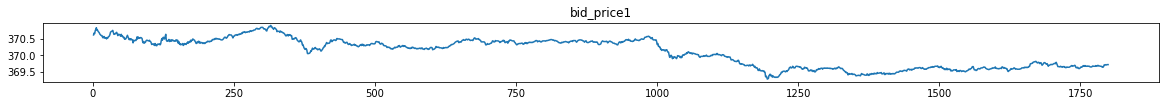

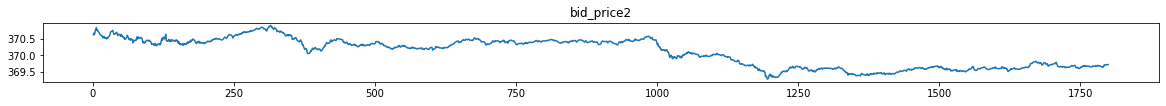

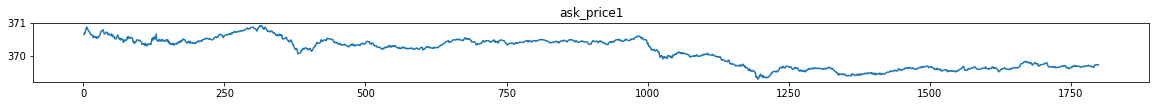

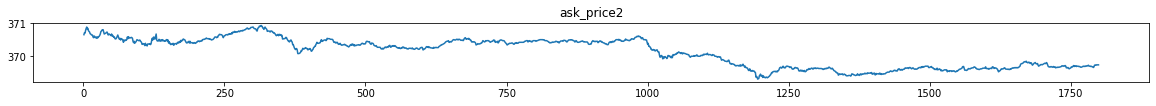

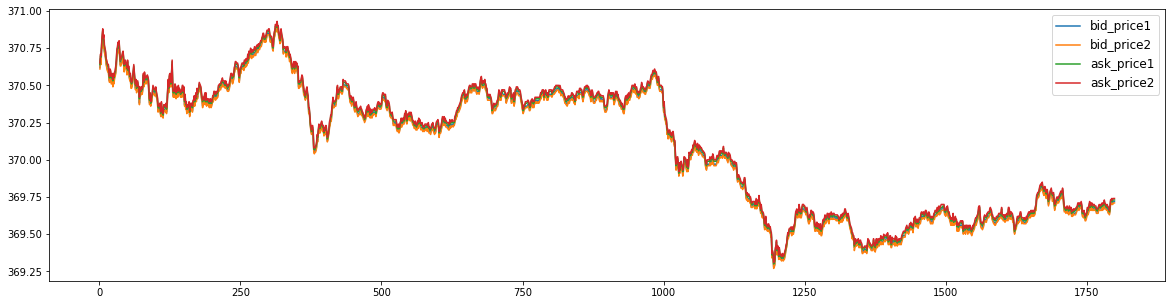

In [12]:
samples = ["bid_price1","bid_price2","ask_price1","ask_price2"]

for num,a in enumerate(samples):
    plt.figure(figsize=(20,5))
   
    plt.subplot(4,1,num+1)
    plt.plot(book_test["seconds_in_bucket"],book_test[a])
    plt.title(a)
plt.show()
plt.figure(figsize=(20,5))

for num,a in enumerate(samples):
    
   
    plt.plot(book_test["seconds_in_bucket"],book_test[a],label=a)
plt.legend(fontsize=12)

In [14]:
trade_example  = trade[trade['stock_id']==50200]
trade_test = trade_example [trade_example ["time_id"]==12]

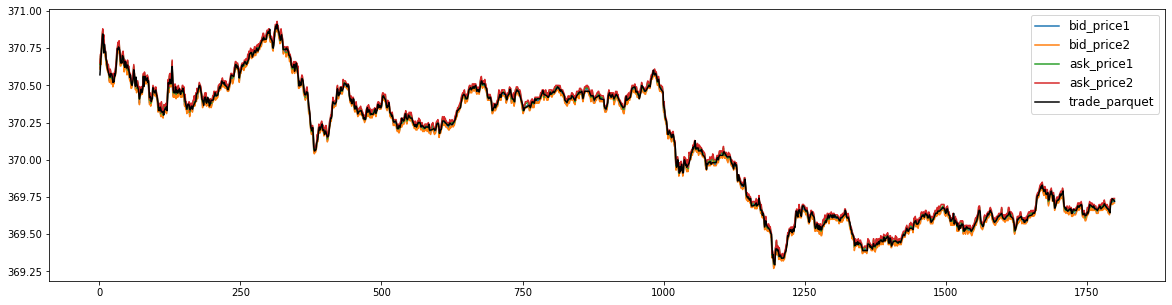

In [18]:
plt.figure(figsize=(20,5))

for num,a in enumerate(samples):
    plt.plot(book_test["seconds_in_bucket"],book_test[a],label=a)
    
plt.plot(trade_test["seconds_in_bucket"],trade_test["price"],label="trade_parquet",color ='black')
plt.legend(fontsize=12)

(array([1443.,  261.,   61.,    6.,   10.,    5.,    2.,    6.,    3.,
           2.]),
 array([1.0000e+00, 3.7090e+02, 7.4080e+02, 1.1107e+03, 1.4806e+03,
        1.8505e+03, 2.2204e+03, 2.5903e+03, 2.9602e+03, 3.3301e+03,
        3.7000e+03]),
 <BarContainer object of 10 artists>)

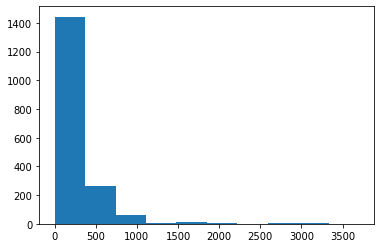

In [20]:
plt.hist(book_test['bid_size1'])

(array([1.297e+03, 3.020e+02, 8.300e+01, 4.300e+01, 1.000e+01, 2.800e+01,
        1.600e+01, 1.000e+01, 9.000e+00, 1.000e+00]),
 array([1.0000e+00, 3.9090e+02, 7.8080e+02, 1.1707e+03, 1.5606e+03,
        1.9505e+03, 2.3404e+03, 2.7303e+03, 3.1202e+03, 3.5101e+03,
        3.9000e+03]),
 <BarContainer object of 10 artists>)

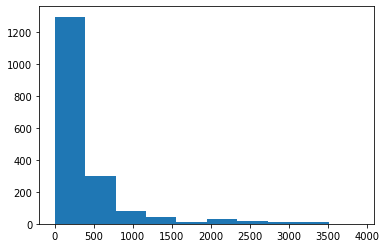

In [21]:
plt.hist(book_test['ask_size1'])

(array([1.218e+03, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.00000e+00, 6.39980e+03, 1.27986e+04, 1.91974e+04, 2.55962e+04,
        3.19950e+04, 3.83938e+04, 4.47926e+04, 5.11914e+04, 5.75902e+04,
        6.39890e+04]),
 <BarContainer object of 10 artists>)

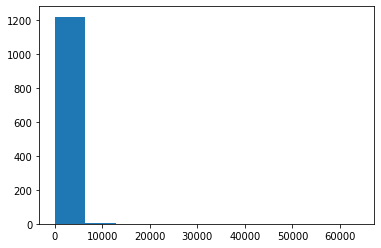

In [22]:
plt.hist(trade_test['size'])